In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy
from GmGM import Dataset, GmGM
from strong_product_model import strong_product_model
from utilities import vec_kron_sum, sim_diag
import random
import BiGLasso_Methods as bg
from typing import Literal
from sklearn.metrics import auc
from collections import OrderedDict

SEED = 0

# Make palette colorblind friendly
plt.style.use('tableau-colorblind10')
hatches = ['|', '//', 'oo', 'x', '+', '-', 'OO', '.', '*', '\\']
lines = ['-', '--', '-.', ':', (0, (3, 5, 1, 5, 1, 5))]

# Prevent type 3 fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
def fast_strong_product(
    Psi_1: np.ndarray,
    Psi_2w: np.ndarray,
    Psi_2b: np.ndarray,
) -> np.ndarray:
    """
    Generates random sample from given parameters
    of the strong product model.
    """
    Theta = Psi_2b + np.eye(Psi_2b.shape[0])
    P, D = sim_diag(Theta, Psi_2w)
    Lam, V = np.linalg.eigh(Psi_1)
    core = 1 / vec_kron_sum([Lam, D])

    # Generate sample
    z = np.random.normal(size=Psi_1.shape[0] * Psi_2w.shape[0])
    z *= np.sqrt(core)
    Z = V @ z.reshape(Psi_1.shape[0], Psi_2w.shape[0]) @ np.linalg.inv(P)

    return Z

fast_strong_product(np.eye(5), np.eye(7), np.eye(7))
    

array([[ 0.60523375,  0.00516914,  0.04480767, -0.12223766,  0.35024426,
         1.07444806, -0.47403513],
       [-0.67811263,  0.77325802, -0.21808886, -0.28446709, -0.57799631,
         0.59026451, -0.10508867],
       [ 0.38204336,  0.1562473 ,  0.13637495, -0.83235749, -0.04899484,
        -0.00898648,  0.08588156],
       [ 0.43585503, -0.73370345, -0.19992161, -0.03014024,  1.17372237,
         0.1958163 , -0.30676614],
       [ 0.06346061, -0.03334808, -0.79680142, -0.09954415,  0.09687513,
         0.36262001,  0.37995012]])

In [4]:
def fast_kronecker_sum_model(
    Psi_1: np.ndarray,
    Psi_2: np.ndarray,
) -> np.ndarray:
    """
    Generates random sample from given parameters
    of the strong product model.
    """
    Lam1, V1 = np.linalg.eigh(Psi_1)
    Lam2, V2 = np.linalg.eigh(Psi_2)
    core = 1 / vec_kron_sum([Lam1, Lam2])

    # Generate sample
    z = np.random.normal(size=Psi_1.shape[0] * Psi_2.shape[0])
    z *= np.sqrt(core)
    Z = V1 @ z.reshape(Psi_1.shape[0], Psi_2.shape[0]) @ V2.T

    return Z

fast_kronecker_sum_model(np.eye(5), np.eye(7))
    

array([[-0.23674117,  0.50843552,  0.5891949 , -0.90707621, -0.72542104,
         0.9797245 , -0.03242132],
       [-1.08700818, -0.3626677 ,  0.60367273, -0.63104054,  0.19728204,
        -0.85629666, -0.30450838],
       [ 0.4831378 ,  1.15498326,  0.05762082,  0.5156926 ,  0.73135274,
         0.27987441, -0.74267592],
       [ 1.03167233,  0.82341885,  0.26098889, -1.16751639, -1.13859829,
        -1.70339174, -0.23770132],
       [ 0.68661868, -1.14668333,  0.20158355, -1.06133037,  0.96794299,
        -0.84817041, -0.0284773 ]])

In [5]:
def fast_kronecker_product_model(
    Psi_1: np.ndarray,
    Psi_2: np.ndarray,
) -> np.ndarray:
    """
    Generates random sample from given parameters
    of the strong product model.
    """
    Lam1, V1 = np.linalg.eigh(Psi_1)
    Lam2, V2 = np.linalg.eigh(Psi_2)
    core = 1 / np.kron(Lam1, Lam2)

    # Generate sample
    z = np.random.normal(size=Psi_1.shape[0] * Psi_2.shape[0])
    z *= np.sqrt(core)
    Z = V1 @ z.reshape(Psi_1.shape[0], Psi_2.shape[0]) @ V2.T

    return Z

fast_kronecker_product_model(np.eye(5), np.eye(7))
    

array([[-0.45535976,  0.55199771, -0.65472323, -0.55421863, -1.31998026,
         0.93502106,  0.50528371],
       [-1.27616792, -0.92078946, -0.88402554,  0.31655432,  0.40740711,
         0.07109128,  1.18341236],
       [ 0.83634931,  0.95052728,  0.45378367, -2.04449457,  0.06612742,
         1.45825242,  0.84962534],
       [ 0.43971966,  1.75156429,  0.26066676,  1.2901994 ,  1.5664827 ,
         1.31073408,  0.48481014],
       [ 0.2552976 , -1.22820587,  0.8111519 ,  0.11603985, -0.40707844,
         0.52084465, -0.32034649]])

In [6]:
def pr_curve(
    ground_truth: np.ndarray,
    output: np.ndarray,
    num_points: int = 1000
) -> tuple[np.ndarray, np.ndarray]:
    """
    Inputs:
        ground_truth: Adjacency matrix of graph
        output: Output of algorithm
        num_points: Number of points to sample

    Outputs:
        (precisions, recalls): Precision-recall curve
    """
    # Setup
    precisions = np.zeros(num_points)
    recalls = np.zeros(num_points)
    thresholds = np.linspace(-0.1, np.max(output), num_points)

    ground_truth = ground_truth != 0
    np.fill_diagonal(ground_truth, 0)

    if (output == np.eye(output.shape[0])).all():
        return None, None

    # Iterate over thresholds
    for i, threshold in enumerate(thresholds):
        # Threshold output
        output_thresholded = (output > threshold).astype(int)
        np.fill_diagonal(output_thresholded, 0)

        # Calculate precision and recall
        true_positives = np.sum(output_thresholded * ground_truth)
        false_positives = np.sum(output_thresholded * (1 - ground_truth))
        false_negatives = np.sum((1 - output_thresholded) * ground_truth)

        if true_positives + false_positives == 0:
            precisions[i] = 1
            recalls[i] = 0
        else:
            precisions[i] = true_positives / (true_positives + false_positives)
            recalls[i] = true_positives / (true_positives + false_negatives)

    return precisions, recalls

def pr_curve_alg(
    ground_truth: np.ndarray,
    alg: callable,
    reg_params: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    """
    Inputs:
        ground_truth: Adjacency matrix of graph
        output: Output of algorithm
        num_points: Number of points to sample

    Outputs:
        (precisions, recalls): Precision-recall curve
    """
    # Setup
    precisions = np.zeros(reg_params.shape[0])
    recalls = np.zeros(reg_params.shape[0])
    #thresholds = np.linspace(0, np.max(output), num_points)

    ground_truth = ground_truth != 0
    np.fill_diagonal(ground_truth, 0)

    # Iterate over reg_params
    for i, param in enumerate(reg_params):
        # Threshold output
        print(f"TeraLasso lambda: {param}")
        output = alg(param)
        output_thresholded = (output != 0).astype(int)
        np.fill_diagonal(output_thresholded, 0)

        # Calculate precision and recall
        true_positives = np.sum(output_thresholded * ground_truth)
        false_positives = np.sum(output_thresholded * (1 - ground_truth))
        false_negatives = np.sum((1 - output_thresholded) * ground_truth)

        if true_positives + false_positives == 0:
            precisions[i] = 1
            recalls[i] = 0
        else:
            precisions[i] = true_positives / (true_positives + false_positives)
            recalls[i] = true_positives / (true_positives + false_negatives)

    return precisions, recalls

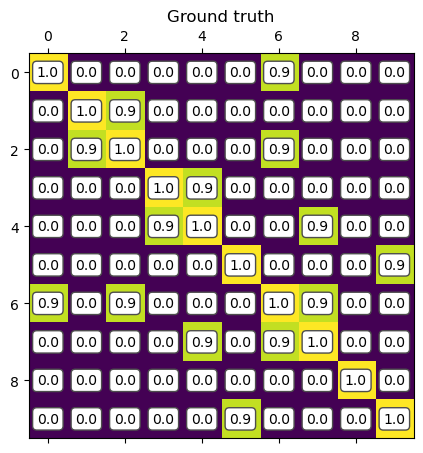

In [7]:
random.seed(SEED)
np.random.seed(SEED)

# Create a random graph
num_nodes = 10
graph = ig.Graph.Erdos_Renyi(n=num_nodes, p=0.1)
ground_truth = np.array(graph.get_adjacency().data)
ground_truth = ground_truth / 1.1 + np.eye(num_nodes)

fig, ax1 = plt.subplots(ncols=1, figsize=(10, 5))
ax1.matshow(ground_truth)
ax1.set_title("Ground truth")

for (i, j), z in np.ndenumerate(ground_truth):
    ax1.text(
        j,
        i,
        '{:0.1f}'.format(z),
        ha='center',
        va='center',
        bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3')
    )

In [8]:
# Create a random graph
def random_graph(graph):
    ground_truth = np.array(graph.get_adjacency().data)
    gt_sums = 1 / np.sqrt(ground_truth.sum(axis=0))
    ground_truth = gt_sums.reshape(1, -1) * ground_truth * gt_sums.reshape(-1, 1)

    # Add diagonal so that it forms a PSD matrix!
    ground_truth = ground_truth / 1.1 + np.eye(num_nodes)
    return ground_truth

def precision_test(
    num_nodes: int,
    graphs: list[ig.Graph],
    title: str,
    num_trials: int = 10,
    model: Literal[
        "Strong Product",
        "Kronecker Sum",
        "Kronecker Product"
    ] = "Strong Product",
    cb_cw_ratio: float = 1.0
) -> tuple[plt.Figure, plt.Axes]:
    random.seed(SEED)
    np.random.seed(SEED)
    
    ground_truth_r = random_graph(graphs[0])
    ground_truth_cw = random_graph(graphs[1]) / np.sqrt(cb_cw_ratio)
    ground_truth_cb = np.sqrt(cb_cw_ratio) * random_graph(graphs[2])

    if model == "Strong Product":
        fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 7))
    elif model == "Kronecker Product":
        fig, (ax1, ax3) = plt.subplots(ncols=2, figsize=(10, 7))
        ax2 = None
    elif model == "Kronecker Sum":
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 7))
        ax3 = None


    algorithms = (
        [
            "Strong Product",
            "GmGM",
            "Strong Product [Kronecker Sum]",
            "Strong Product [Kronecker Product]",
            #"TeraLasso",
        ]
    )
    for idx, algorithm in enumerate(algorithms):
        print(f"Running {algorithm}")
        ps_r = []
        rs_r = []
        ps_cw = []
        rs_cw = []
        ps_cb = []
        rs_cb = []

        for i in range(num_trials):
            print(f"\tTrial {i+1} of {num_trials}")

            # Generate data
            #dfs = num_nodes
            #data_dependencies = stats.wishart(df=dfs, scale=np.eye(num_nodes)).rvs()
            #data_dependencies /= dfs
            if model == "Strong Product":
                output = fast_strong_product(
                    ground_truth_r,
                    ground_truth_cw,
                    ground_truth_cb
                )
            elif model == "Kronecker Sum":
                output = fast_kronecker_sum_model(
                    ground_truth_r,
                    ground_truth_cw
                )
            elif model == "Kronecker Product":
                output = fast_kronecker_product_model(
                    ground_truth_r,
                    ground_truth_cb
                )
            else:
                raise Exception(f"Unknown model: {model}")

            dataset = Dataset(
                dataset={"data": output[np.newaxis, :, :]},
                structure={"data": ("", "rows", "columns")}
            )
            result = None
            run_alg = None
            if algorithm == "GmGM":
                class result_container:
                    # Jerry-rigged class to hold the result
                    def __init__(self, precmats):
                        self.precision_matrices = precmats
                        self.precision_matrices["rows"] = precmats["rows"]
                        self.precision_matrices["cols_between_rows"] = np.eye(num_nodes)
                        self.precision_matrices["cols_within_rows"] = precmats["columns"]
                result = GmGM(
                    dataset,
                    to_keep=0.5,
                    threshold_method="statistical-significance",
                    min_edges={"rows": num_nodes - 1, "columns": num_nodes - 1},
                    n_comps=None,
                    verbose=False,
                    centering_method=None,
                    use_nonparanormal_skeptic=False,
                    nonparanormal_evec_backend="COCA",
                    readonly=False,
                    calculate_explained_variance=True,
                    batch_size=1000
                )
                result = result_container(result.precision_matrices)
            elif algorithm == "Strong Product":
                class result_container:
                    # Jerry-rigged class to hold the result
                    def __init__(self, precmats):
                        self.precision_matrices = precmats
                        self.precision_matrices["rows"] = precmats["rows"]
                        self.precision_matrices["cols_between_rows"] = precmats["cols_between_rows"]
                        self.precision_matrices["cols_within_rows"] = precmats["cols_within_rows"]
                result = strong_product_model(
                    data_matrix=output,
                    rho_rows=0.1,
                    rho_cols_within_rows=0.1,
                    rho_cols_between_rows=0.1,
                    verbose=False,
                    tol=1e-3
                )
                result = result_container(result)
            elif algorithm == "Strong Product [Kronecker Sum]":
                class result_container:
                    # Jerry-rigged class to hold the result
                    def __init__(self, precmats):
                        self.precision_matrices = precmats
                        self.precision_matrices["rows"] = precmats["rows"]
                        self.precision_matrices["cols_between_rows"] = precmats["cols_between_rows"]
                        self.precision_matrices["cols_within_rows"] = precmats["cols_within_rows"]
                result = strong_product_model(
                    data_matrix=output,
                    rho_rows=0.1,
                    rho_cols_within_rows=0.1,
                    rho_cols_between_rows=0.1,
                    verbose=False,
                    tol=1e-3,
                    fix_Theta=True
                )
                result = result_container(result)
            elif algorithm == "Strong Product [Kronecker Product]":
                class result_container:
                    # Jerry-rigged class to hold the result
                    def __init__(self, precmats):
                        self.precision_matrices = precmats
                        self.precision_matrices["rows"] = precmats["rows"]
                        self.precision_matrices["cols_between_rows"] = precmats["cols_between_rows"]
                        self.precision_matrices["cols_within_rows"] = precmats["cols_within_rows"]
                result = strong_product_model(
                    data_matrix=output,
                    rho_rows=0.1,
                    rho_cols_within_rows=0.1,
                    rho_cols_between_rows=0.1,
                    verbose=False,
                    tol=1e-3,
                    fix_Psi_2w=True
                )
                result = result_container(result)
            elif algorithm == "TeraLasso":
                def alg(reg_param):
                    return bg.TeraLasso(
                        dataset,
                        reg_param,
                        use_nonparanormal_skeptic=False
                    ).precision_matrices["rows"].toarray()
                run_alg = alg
            else:
                raise Exception(f"Unknown algorithm: {algorithm}")

            if run_alg is None:
                if hasattr(result.precision_matrices["rows"], 'toarray'):
                    result.precision_matrices["rows"] = result.precision_matrices["rows"].toarray()
                if hasattr(result.precision_matrices["cols_within_rows"], 'toarray'):
                    result.precision_matrices["cols_within_rows"] = \
                        result.precision_matrices["cols_within_rows"].toarray()
                if hasattr(result.precision_matrices["cols_between_rows"], 'toarray'):
                    result.precision_matrices["cols_between_rows"] = \
                        result.precision_matrices["cols_between_rows"].toarray()
                ys_r, xs_r = pr_curve(ground_truth_r, result.precision_matrices["rows"])
                ys_cw, xs_cw = pr_curve(ground_truth_cw, result.precision_matrices["cols_within_rows"])
                ys_cb, xs_cb = pr_curve(ground_truth_cb, result.precision_matrices["cols_between_rows"])
            else:
                # Manually chosen bounds to cover span from ~perfect recall to ~perfect precision
                if algorithm == "TeraLasso":
                    reg_params = 10**np.linspace(-2, 0, 25)
                ys_r, xs_r = pr_curve_alg(ground_truth_r, run_alg, reg_params)
                ys_cw, xs_cw = pr_curve_alg(ground_truth_cw, run_alg, reg_params)
                ys_cb, xs_cb = pr_curve_alg(ground_truth_cb, run_alg, reg_params)
                #print(ys, xs)
            
            if ys_r is not None and xs_r is not None:
                ps_r.append(ys_r)
                rs_r.append(xs_r)
            if ys_cw is not None and xs_cw is not None:
                ps_cw.append(ys_cw)
                rs_cw.append(xs_cw)
            if ys_cb is not None and xs_cb is not None:
                ps_cb.append(ys_cb)
                rs_cb.append(xs_cb)


        num_points = 100
        xs = np.linspace(0, 1, num_points)

        if algorithm == "GmGM":
            label = "GmGM"
        elif algorithm == "TeraLasso":
            label = "TeraLasso"
        elif algorithm == "Strong Product":
            label = "Strong Product"
        elif algorithm == "Strong Product [Kronecker Sum]":
            label = "Kronecker Sum"
        elif algorithm == "Strong Product [Kronecker Product]":
            label = "Kronecker Product"
        else:
            raise Exception(f"Unknown algorithm: {algorithm}")

        if algorithm == "TeraLasso":
            # Tableau color is too light
            lineplot = ax1.plot(-1, -1, color='#888888')
        elif algorithm == "TeraLasso + mean estimation":
            lineplot = ax1.plot(-1, -1, color='#990000')
        else:
            lineplot = ax1.plot(-1, -1)
        xs = np.linspace(0.01, 1, 100)

        for ps, rs, ax in zip([ps_r, ps_cw, ps_cb], [rs_r, rs_cw, rs_cb], [ax1, ax2, ax3]):
            if ax is None:
                continue
            min_ys = np.zeros(100) + 1
            max_ys = np.zeros(100)
            if len(ps) == 0:
                continue
            for p, r in zip(ps, rs):
                f = scipy.interpolate.interp1d(r, p, kind='linear', fill_value='extrapolate')
                min_ys = np.minimum(min_ys, f(xs))
                max_ys = np.maximum(max_ys, f(xs))
                #plt.plot(xs, f(xs), color='black', alpha=0.1)
            ax.plot(
                xs,
                min_ys,
                color=lineplot[0].get_color(),
                linestyle=lines[idx],
                alpha=0.3
            )
            ax.plot(
                xs,
                max_ys,
                color=lineplot[0].get_color(),
                linestyle=lines[idx],
                alpha=0.3
            )
            # ax.plot(
            #     xs,
            #     (min_ys + max_ys) / 2,
            #     color=lineplot[0].get_color(),
            #     label=label,
            #     linestyle=lines[idx]
            # )
            ax.plot(
                sum(rs) / len(rs),
                sum(ps) / len(ps),
                color=lineplot[0].get_color(),
                label=label,
                linestyle=lines[idx]
            )
            ax.fill_between(
                xs,
                min_ys,
                max_ys,
                color=lineplot[0].get_color(),
                alpha=0.1
            )#, hatch=hatches[idx]+hatches[idx])

    for ax in [ax1, ax2, ax3]:
        if ax is None:
            continue
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xlabel('Recall\n\n')
        ax.set_ylabel('Precision')
        #ax.legend()

    if ax1 is not None:
        ax1.set_title("Rows")
    if ax2 is not None:
        ax2.set_title("Columns\n(within-row)")
    if ax3 is not None:
        ax3.set_title("Columns\n(between-row)")

    # Increase font size
    for ax in [ax1, ax2, ax3]:
        if ax is None:
            continue
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
            item.set_fontsize(24)
        for item in ax.get_xticklabels() + ax.get_yticklabels():
            item.set_fontsize(16)

    # Increase legend font size
    handles = []
    labels = []
    for ax in [ax1, ax2, ax3]:
        if ax is None:
            continue
        #ax.legend(prop={'size': 12})
        _handles, _labels = ax.get_legend_handles_labels()
        handles.extend(_handles)
        labels.extend(_labels)

    # Put in ordered dict to remove duplicate labels
    _dict = OrderedDict(zip(labels, handles))
    fig.legend(_dict.values(), _dict.keys(), loc='lower center', ncol=5, fontsize=24)

    if model == "Strong Product":
        axs = (ax1, ax2, ax3)
    elif model == "Kronecker Product":
        axs = (ax1, ax3)
    elif model == "Kronecker Sum":
        axs = (ax1, ax2)

    fig.suptitle(
            f'PR Curves for Barabasi-Albert graph ({num_nodes} nodes)'
            + f'\n [{title}]',
            size=24
        )

    fig.tight_layout()
    
    return fig, axs

# Run Tests

Running Strong Product
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running GmGM
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running Strong Product [Kronecker Sum]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running Strong Product [Kronecker Product]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10


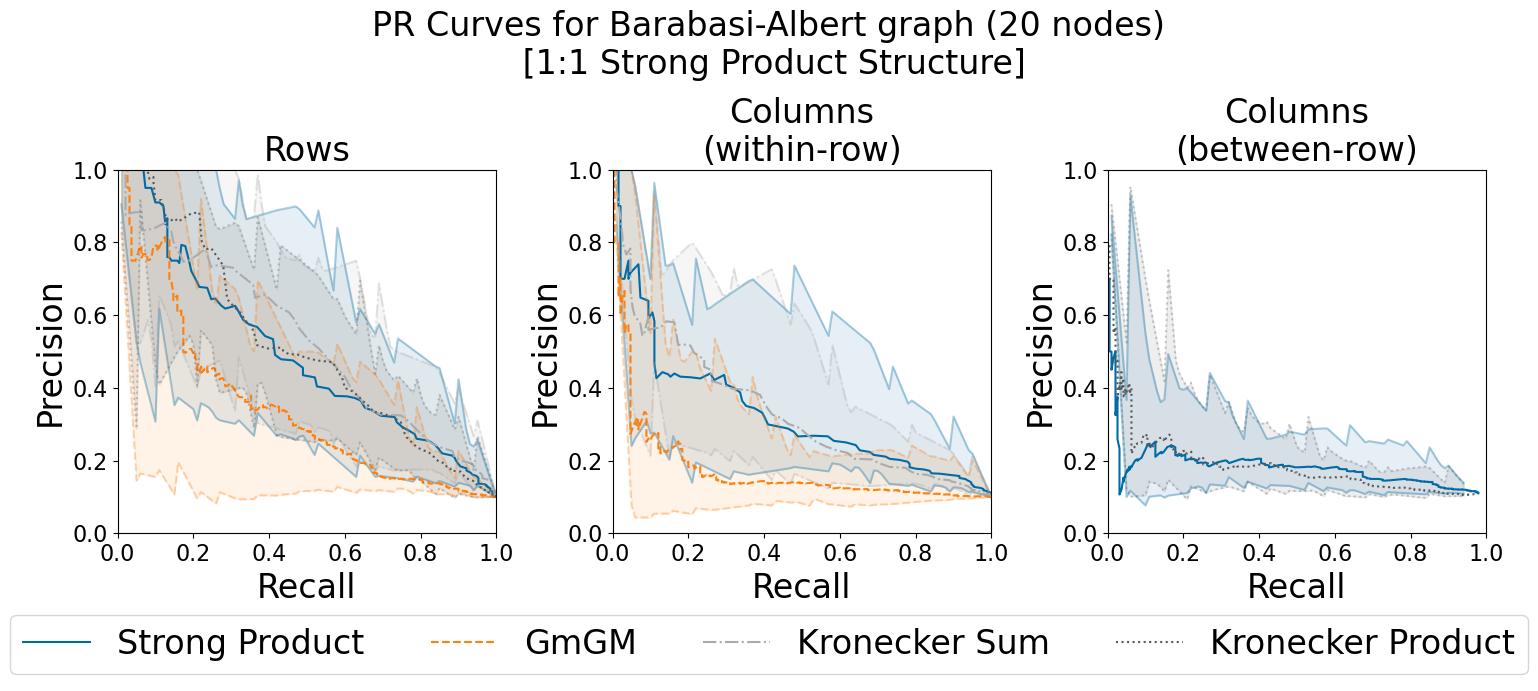

In [70]:
# This is a quick tester line to ensure the figure gets generated properly.
# Ignore it.

# Create a random graph
num_nodes = 20
graph1 = ig.Graph.Barabasi(n=num_nodes)
graph2 = ig.Graph.Barabasi(n=num_nodes)
graph3 = ig.Graph.Barabasi(n=num_nodes)



fig, axs = precision_test(
    num_nodes,
    [graph1, graph2, graph3],
    title="1:1 Strong Product Structure",
    num_trials=10,
    model="Strong Product",
    cb_cw_ratio=1
)
fig.savefig("out_figs/synthetic/TEST.pdf", bbox_inches='tight')

Running Strong Product
	Trial 1 of 10
logm result may be inaccurate, approximate err = 0.024406051489619506
logm result may be inaccurate, approximate err = 4.5152271122963575e-05
logm result may be inaccurate, approximate err = 4.533747795989139e-05
logm result may be inaccurate, approximate err = 4.5432294903991494e-05
logm result may be inaccurate, approximate err = 4.55028474604307e-05
logm result may be inaccurate, approximate err = 4.5514582465596844e-05
logm result may be inaccurate, approximate err = 4.551462832698715e-05
logm result may be inaccurate, approximate err = 4.551466273014689e-05
logm result may be inaccurate, approximate err = 4.551467204546231e-05
logm result may be inaccurate, approximate err = 1.1036465429749205e-06
	Trial 2 of 10
logm result may be inaccurate, approximate err = 0.024190362843689923
logm result may be inaccurate, approximate err = 0.02504351410623382
logm result may be inaccurate, approximate err = 4.564495636015622e-05
logm result may be inaccu

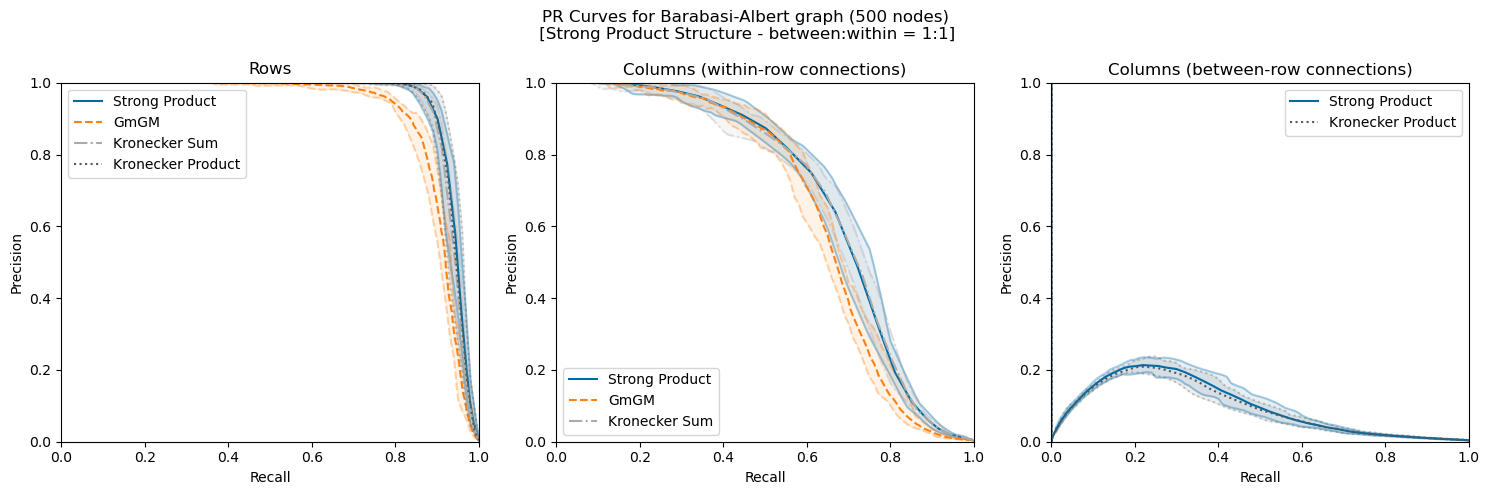

In [19]:
# Create a random graph
num_nodes = 500
graph1 = ig.Graph.Barabasi(n=num_nodes)
graph2 = ig.Graph.Barabasi(n=num_nodes)
graph3 = ig.Graph.Barabasi(n=num_nodes)



fig, axs = precision_test(
    num_nodes,
    [graph1, graph2, graph3],
    title="Strong Product Structure - between:within = 1:1",
    num_trials=10,
    model="Strong Product",
    cb_cw_ratio=1
)
fig.savefig('./out_figs/synthetic/sp1_barabasi_500_nodes_1to1.pdf', bbox_inches="tight")

Running Strong Product
	Trial 1 of 10
logm result may be inaccurate, approximate err = 0.02384652536913233
logm result may be inaccurate, approximate err = 0.02463981649722635
logm result may be inaccurate, approximate err = 1.4454702675371343e-06
logm result may be inaccurate, approximate err = 4.533211648671937e-05
logm result may be inaccurate, approximate err = 2.2803971693415856e-05
logm result may be inaccurate, approximate err = 4.514904519283054e-05
logm result may be inaccurate, approximate err = 4.514905651430727e-05
	Trial 2 of 10
logm result may be inaccurate, approximate err = 0.024024827562821673
logm result may be inaccurate, approximate err = 3.4847814044694365e-05
logm result may be inaccurate, approximate err = 4.4930494082797115e-05
logm result may be inaccurate, approximate err = 1.3536286975987022e-06
logm result may be inaccurate, approximate err = 4.493603977061886e-05
logm result may be inaccurate, approximate err = 4.493653674457296e-05
logm result may be inacc

/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:229: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running Strong Product [Kronecker Sum]
	Trial 1 of 10
	Trial 2 of 10
logm result may be inaccurate, approximate err = 3.638925189879876e-12
	Trial 3 of 10
logm result may be inaccurate, approximate err = 3.4197692721976446e-12
	Trial 4 of 10
logm result may be inaccurate, approximate err = 1.304555605290852e-06
	Trial 5 of 10
logm result may be inaccurate, approximate err = 3.534357178374883e-12
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
logm result may be inaccurate, approximate err = 4.294721506979689e-12
	Trial 10 of 10
logm result may be inaccurate, approximate err = 3.401741117700221e-12
Running Strong Product [Kronecker Product]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10


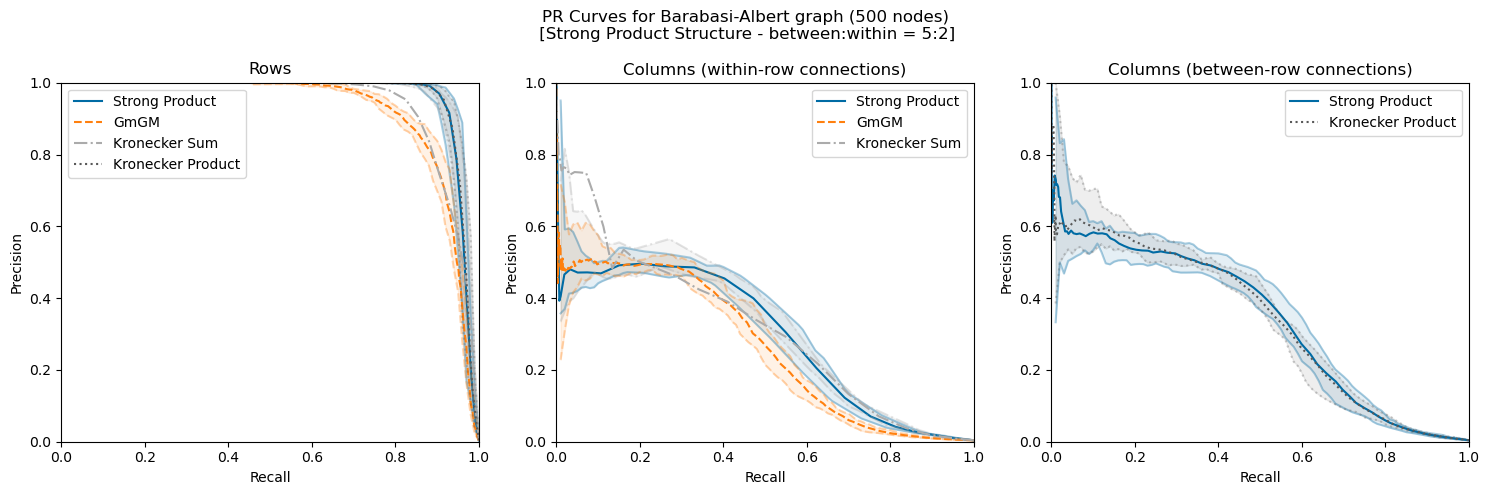

In [18]:
# Create a random graph
num_nodes = 500
graph1 = ig.Graph.Barabasi(n=num_nodes)
graph2 = ig.Graph.Barabasi(n=num_nodes)
graph3 = ig.Graph.Barabasi(n=num_nodes)



fig, axs = precision_test(
    num_nodes,
    [graph1, graph2, graph3],
    title="Strong Product Structure - between:within = 5:2",
    num_trials=10,
    model="Strong Product",
    cb_cw_ratio=2.5
)
fig.savefig('./out_figs/synthetic/sp1_barabasi_500_nodes.pdf', bbox_inches="tight")

Running Strong Product
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running GmGM
	Trial 1 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:229: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running Strong Product [Kronecker Sum]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running Strong Product [Kronecker Product]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10


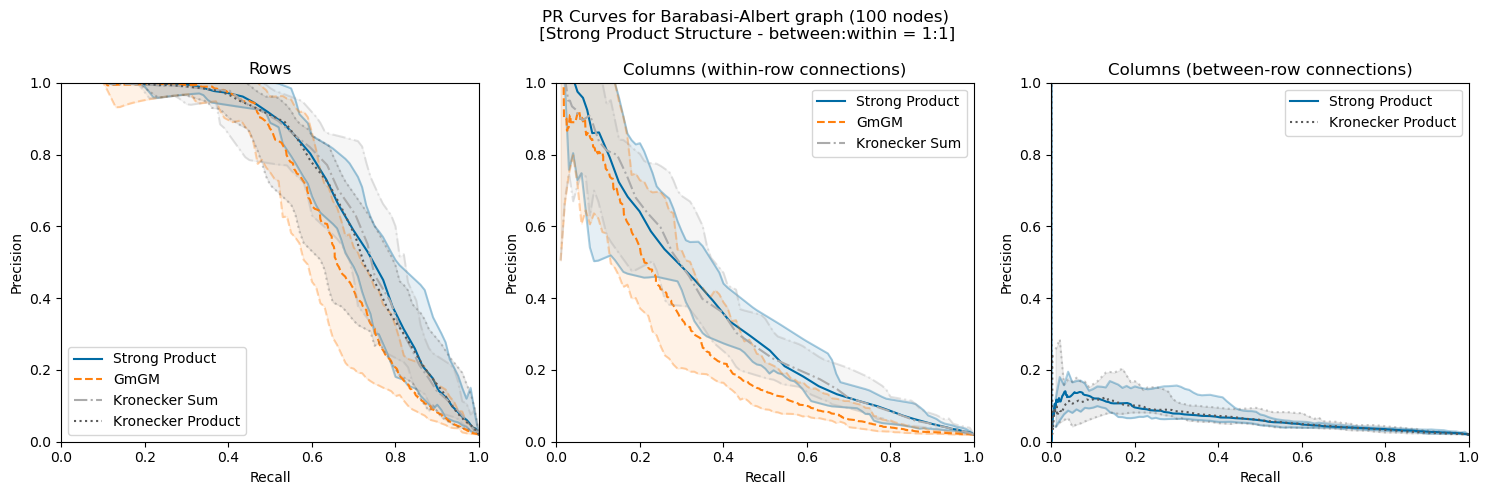

In [9]:
# Create a random graph
num_nodes = 100
graph1 = ig.Graph.Barabasi(n=num_nodes)
graph2 = ig.Graph.Barabasi(n=num_nodes)
graph3 = ig.Graph.Barabasi(n=num_nodes)



fig, axs = precision_test(
    num_nodes,
    [graph1, graph2, graph3],
    title="Strong Product Structure - between:within = 1:1",
    num_trials=10,
    model="Strong Product",
    cb_cw_ratio=1.0
)
fig.savefig('./out_figs/synthetic/sp1_barabasi.pdf', bbox_inches="tight")

Running Strong Product
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running GmGM
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running Strong Product [Kronecker Sum]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running Strong Product [Kronecker Product]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10


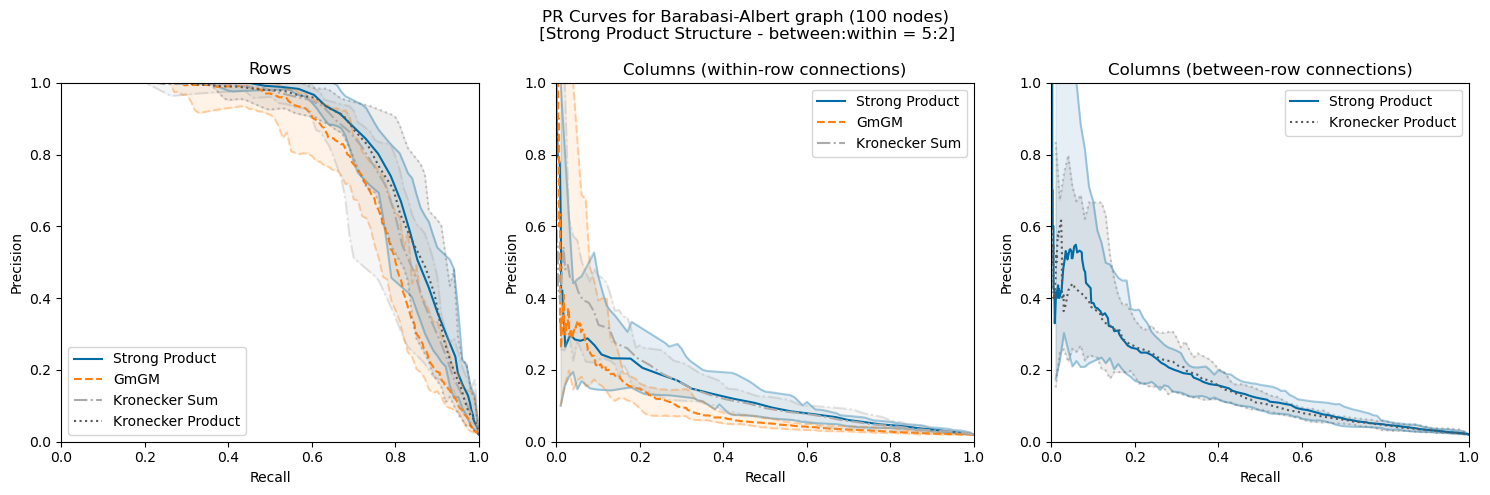

In [10]:
# Create a random graph
num_nodes = 100
graph1 = ig.Graph.Barabasi(n=num_nodes)
graph2 = ig.Graph.Barabasi(n=num_nodes)
graph3 = ig.Graph.Barabasi(n=num_nodes)



fig, axs = precision_test(
    num_nodes,
    [graph1, graph2, graph3],
    title="Strong Product Structure - between:within = 5:2",
    num_trials=10,
    model="Strong Product",
    cb_cw_ratio=2.5
)
fig.savefig('./out_figs/synthetic/sp5_2_barabasi.pdf', bbox_inches="tight")

Running Strong Product
	Trial 1 of 10
logm result may be inaccurate, approximate err = 4.301683440106249e-05
logm result may be inaccurate, approximate err = 4.326655561085427e-05
logm result may be inaccurate, approximate err = 4.349464675089985e-05
logm result may be inaccurate, approximate err = 2.758373524022052e-05
logm result may be inaccurate, approximate err = 4.329355213267222e-05
logm result may be inaccurate, approximate err = 4.329395781979673e-05
logm result may be inaccurate, approximate err = 2.378043388731475e-06
logm result may be inaccurate, approximate err = 2.378043388421778e-06
	Trial 2 of 10
logm result may be inaccurate, approximate err = 4.353640766407616e-05
logm result may be inaccurate, approximate err = 4.365563428341408e-05
logm result may be inaccurate, approximate err = 1.998052377399056e-06
logm result may be inaccurate, approximate err = 2.8832318678049577e-05
logm result may be inaccurate, approximate err = 4.368824619700838e-05
logm result may be inac

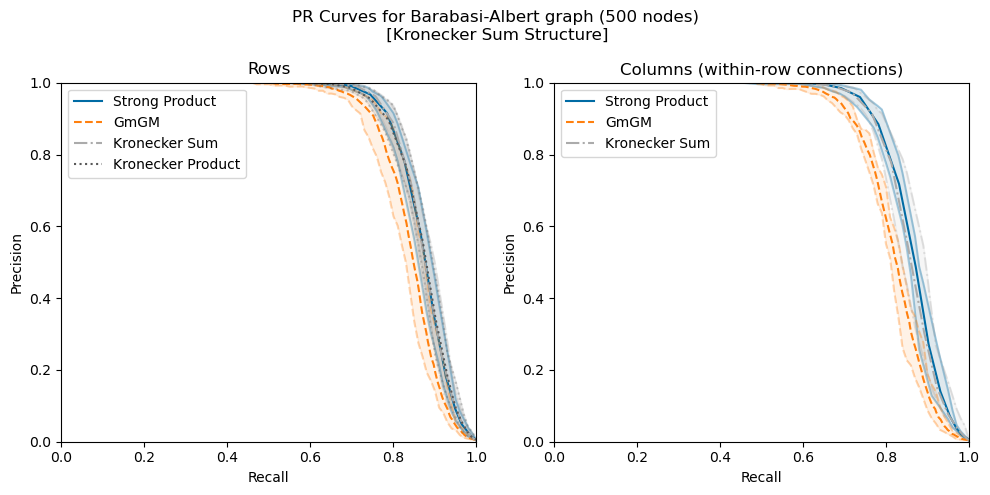

In [20]:
# Create a random graph
num_nodes = 500
graph1 = ig.Graph.Barabasi(n=num_nodes)
graph2 = ig.Graph.Barabasi(n=num_nodes)
graph3 = ig.Graph.Barabasi(n=num_nodes)



fig, axs = precision_test(
    num_nodes,
    [graph1, graph2, graph3],
    title="Kronecker Sum Structure",
    num_trials=10,
    model="Kronecker Sum"
)
fig.savefig('./out_figs/synthetic/ks_barabasi_500.pdf', bbox_inches="tight")

Running Strong Product
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running GmGM
	Trial 1 of 10


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:112: UserWarning: `use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored
  warnings.warn("`use_nonparanormal_skeptic` is false, so `nonparanormal_evec_backend` is ignored")
/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:229: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running Strong Product [Kronecker Sum]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running Strong Product [Kronecker Product]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10


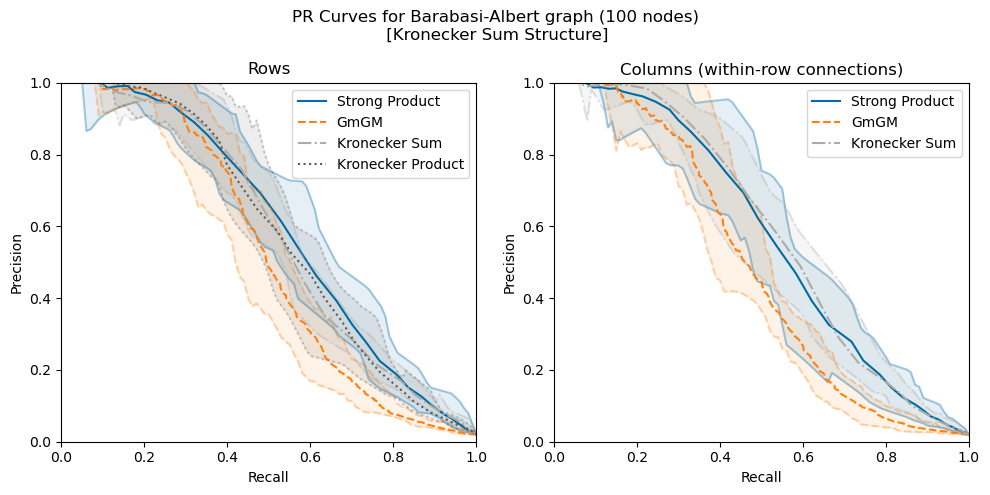

In [11]:
# Create a random graph
num_nodes = 100
graph1 = ig.Graph.Barabasi(n=num_nodes)
graph2 = ig.Graph.Barabasi(n=num_nodes)
graph3 = ig.Graph.Barabasi(n=num_nodes)



fig, axs = precision_test(
    num_nodes,
    [graph1, graph2, graph3],
    title="Kronecker Sum Structure",
    num_trials=10,
    model="Kronecker Sum"
)
fig.savefig('./out_figs/synthetic/ks_barabasi.pdf', bbox_inches="tight")

Running Strong Product
	Trial 1 of 10
logm result may be inaccurate, approximate err = 0.049490058544173585
logm result may be inaccurate, approximate err = 3.9566458099191495e-05
logm result may be inaccurate, approximate err = 2.9558273399665395e-06
logm result may be inaccurate, approximate err = 3.96077974581326e-05
logm result may be inaccurate, approximate err = 3.6066543214850556e-13
logm result may be inaccurate, approximate err = 3.9608584282039916e-05
logm result may be inaccurate, approximate err = 3.960871541585123e-05
logm result may be inaccurate, approximate err = 3.9608780975971235e-05
logm result may be inaccurate, approximate err = 3.9155191377493355e-05
logm result may be inaccurate, approximate err = 3.6202150650518084e-13
logm result may be inaccurate, approximate err = 3.9608838345183066e-05
logm result may be inaccurate, approximate err = 3.9608838853629846e-05
logm result may be inaccurate, approximate err = 3.5888599643349397e-13
logm result may be inaccurate, 

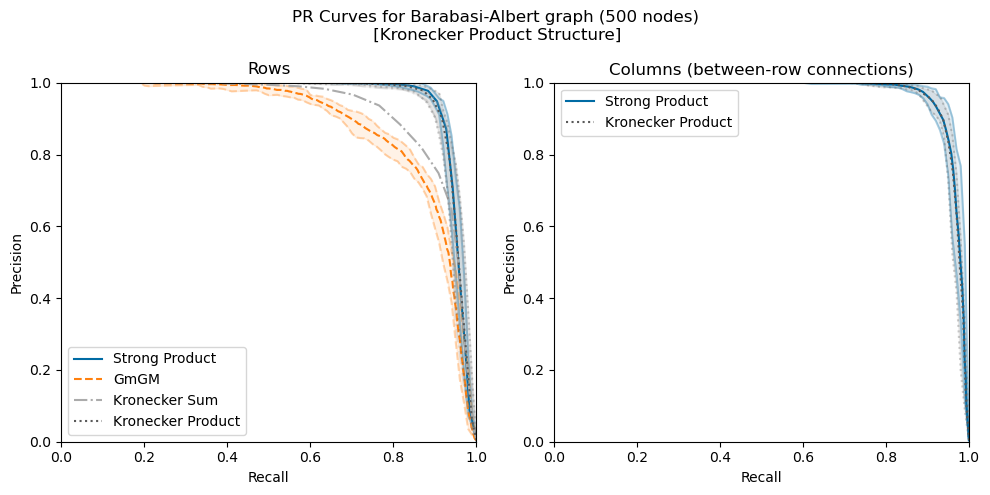

In [21]:
# Create a random graph
num_nodes = 500
graph1 = ig.Graph.Barabasi(n=num_nodes)
graph2 = ig.Graph.Barabasi(n=num_nodes)
graph3 = ig.Graph.Barabasi(n=num_nodes)



fig, axs = precision_test(
    num_nodes,
    [graph1, graph2, graph3],
    title="Kronecker Product Structure",
    num_trials=10,
    model="Kronecker Product"
)
fig.savefig('./out_figs/synthetic/kp_barabasi_500.pdf', bbox_inches="tight")

Running Strong Product
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running GmGM
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running Strong Product [Kronecker Sum]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10
Running Strong Product [Kronecker Product]
	Trial 1 of 10
	Trial 2 of 10
	Trial 3 of 10
	Trial 4 of 10
	Trial 5 of 10
	Trial 6 of 10
	Trial 7 of 10
	Trial 8 of 10
	Trial 9 of 10
	Trial 10 of 10


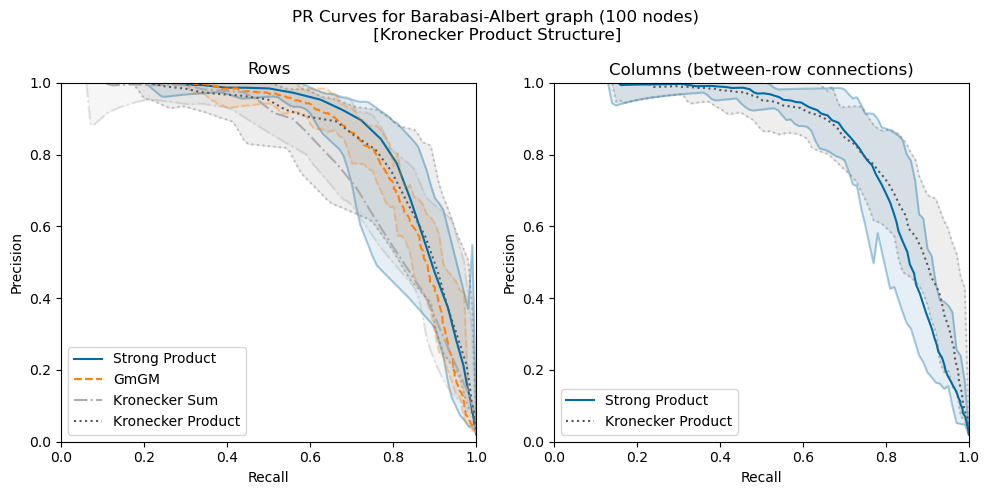

In [12]:
# Create a random graph
num_nodes = 100
graph1 = ig.Graph.Barabasi(n=num_nodes)
graph2 = ig.Graph.Barabasi(n=num_nodes)
graph3 = ig.Graph.Barabasi(n=num_nodes)



fig, axs = precision_test(
    num_nodes,
    [graph1, graph2, graph3],
    title="Kronecker Product Structure",
    num_trials=10,
    model="Kronecker Product"
)
fig.savefig('./out_figs/synthetic/kp_barabasi.pdf', bbox_inches="tight")

# AUPR cb-ratio

In [9]:
def aupr(
    num_nodes: int,
    graphs: list[ig.Graph],
    cb_cw_ratio: float = 1.0,
    row_coefficient: float = 1.0
) -> tuple[float]:

    # Create a random graph
    def random_graph(graph):
        ground_truth = np.array(graph.get_adjacency().data)
        gt_sums = 1 / np.sqrt(ground_truth.sum(axis=0))
        ground_truth = gt_sums.reshape(1, -1) * ground_truth * gt_sums.reshape(-1, 1)

        # Add diagonal so that it forms a PSD matrix!
        ground_truth = ground_truth / 1.1 + np.eye(num_nodes)
        return ground_truth
    
    ground_truth_r = row_coefficient * random_graph(graphs[0])
    ground_truth_cw = random_graph(graphs[1]) / np.sqrt(cb_cw_ratio)
    ground_truth_cb = np.sqrt(cb_cw_ratio) * random_graph(graphs[2])

    ps_r = []
    rs_r = []
    ps_cw = []
    rs_cw = []
    ps_cb = []
    rs_cb = []

    output = fast_strong_product(
        ground_truth_r,
        ground_truth_cw,
        ground_truth_cb
    )

    result = None
    class result_container:
        # Jerry-rigged class to hold the result
        def __init__(self, precmats):
            self.precision_matrices = precmats
            self.precision_matrices["rows"] = precmats["rows"]
            self.precision_matrices["cols_between_rows"] = precmats["cols_between_rows"]
            self.precision_matrices["cols_within_rows"] = precmats["cols_within_rows"]
    result = strong_product_model(
        data_matrix=output,
        rho_rows=0.1,
        rho_cols_within_rows=0.1,
        rho_cols_between_rows=0.1,
        verbose=False,
        tol=1e-3
    )
    result = result_container(result)

    ys_r, xs_r = pr_curve(ground_truth_r, result.precision_matrices["rows"])
    ys_cw, xs_cw = pr_curve(ground_truth_cw, result.precision_matrices["cols_within_rows"])
    ys_cb, xs_cb = pr_curve(ground_truth_cb, result.precision_matrices["cols_between_rows"])
    
    if ys_r is not None and xs_r is not None:
        ps_r.append(ys_r)
        rs_r.append(xs_r)
    if ys_cw is not None and xs_cw is not None:
        ps_cw.append(ys_cw)
        rs_cw.append(xs_cw)
    if ys_cb is not None and xs_cb is not None:
        ps_cb.append(ys_cb)
        rs_cb.append(xs_cb)

    return auc(xs_r, ys_r), auc(xs_cw, ys_cw), auc(xs_cb, ys_cb)

Iteration 1, Ratio 0.01
Iteration 3, Ratio 5.005
Iteration 5, Ratio 10.0


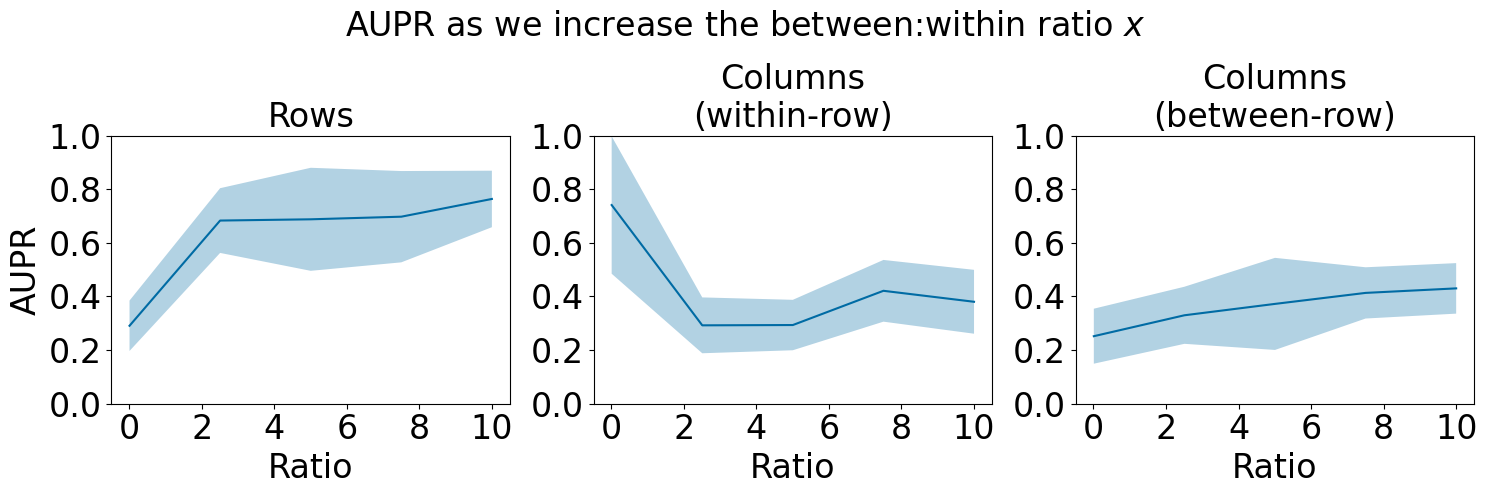

In [15]:
# This is a quick tester cell to ensure the figure gets generated properly.

random.seed(SEED)
np.random.seed(SEED)

# Create a random graph
num_nodes = 10
num_trials = 10
cb_ratios = np.linspace(0.01, 10, 5)

aus_1 = []
aus_2w = []
aus_2b = []
aus_1_var = []
aus_2w_var = []
aus_2b_var = []

for i, cb_ratio in enumerate(cb_ratios):
    graph1 = ig.Graph.Barabasi(n=num_nodes)
    graph2 = ig.Graph.Barabasi(n=num_nodes)
    graph3 = ig.Graph.Barabasi(n=num_nodes)
    if i % 2 == 0:
        print(f"Iteration {i+1}, Ratio {cb_ratio}")
    _aus_1 = []
    _aus_2w = []
    _aus_2b = []
    for trial in range(num_trials):
        au_1, au_2w, au_2b = aupr(
            num_nodes,
            [graph1, graph2, graph3],
            cb_cw_ratio=cb_ratio
        )
        _aus_1.append(au_1)
        _aus_2w.append(au_2w)
        _aus_2b.append(au_2b)
    aus_1.append(np.mean(_aus_1))
    aus_2w.append(np.mean(_aus_2w))
    aus_2b.append(np.mean(_aus_2b))
    aus_1_var.append(np.var(_aus_1 - aus_1[-1]))
    aus_2w_var.append(np.var(_aus_2w - aus_2w[-1]))
    aus_2b_var.append(np.var(_aus_2b - aus_2b[-1]))

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))
ax1.plot(cb_ratios, aus_1, label="Rows")
ax1.set_title("Rows")
ax2.plot(cb_ratios, aus_2w, label="Columns (within-row)")
ax2.set_title("Columns\n(within-row)")
ax3.plot(cb_ratios, aus_2b, label="Columns (between-row)")
ax3.set_title("Columns\n(between-row)")
ax1.set_xlabel("Ratio")
ax2.set_xlabel("Ratio")
ax3.set_xlabel("Ratio")
ax1.set_ylabel("AUPR")

ax1.fill_between(
    cb_ratios,
    np.array(aus_1) - np.sqrt(np.array(aus_1_var)),
    np.array(aus_1) + np.sqrt(np.array(aus_1_var)),
    alpha=0.3
)
ax2.fill_between(
    cb_ratios,
    np.array(aus_2w) - np.sqrt(np.array(aus_2w_var)),
    np.array(aus_2w) + np.sqrt(np.array(aus_2w_var)),
    alpha=0.3
)
ax3.fill_between(
    cb_ratios,
    np.array(aus_2b) - np.sqrt(np.array(aus_2b_var)),
    np.array(aus_2b) + np.sqrt(np.array(aus_2b_var)),
    alpha=0.3
)

ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)
ax3.set_ylim(0, 1)

# Increase font size
for ax in [ax1, ax2, ax3]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(24)

fig.suptitle("AUPR as we increase the between:within ratio $x$", size=24)
fig.tight_layout()

fig.savefig('./out_figs/synthetic/TEST2.pdf', bbox_inches="tight")

Iteration 1, Ratio 0.01
Iteration 3, Ratio 0.8425
Iteration 5, Ratio 1.675
Iteration 7, Ratio 2.5075
Iteration 9, Ratio 3.34
Iteration 11, Ratio 4.172499999999999
Iteration 13, Ratio 5.005
Iteration 15, Ratio 5.8375
Iteration 17, Ratio 6.67
Iteration 19, Ratio 7.5024999999999995
Iteration 21, Ratio 8.334999999999999
Iteration 23, Ratio 9.1675
Iteration 25, Ratio 10.0


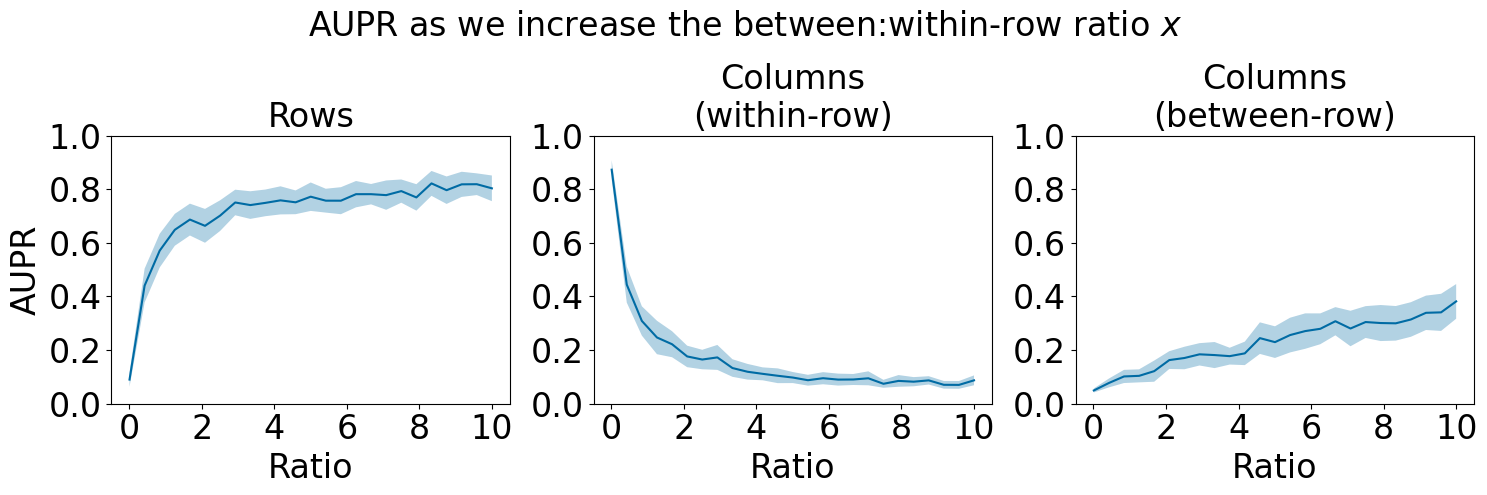

In [16]:
random.seed(SEED)
np.random.seed(SEED)

# Create a random graph
num_nodes = 50
num_trials = 50
cb_ratios = np.linspace(0.01, 10, 25)

aus_1 = []
aus_2w = []
aus_2b = []
aus_1_var = []
aus_2w_var = []
aus_2b_var = []

for i, cb_ratio in enumerate(cb_ratios):
    graph1 = ig.Graph.Barabasi(n=num_nodes)
    graph2 = ig.Graph.Barabasi(n=num_nodes)
    graph3 = ig.Graph.Barabasi(n=num_nodes)
    if i % 2 == 0:
        print(f"Iteration {i+1}, Ratio {cb_ratio}")
    _aus_1 = []
    _aus_2w = []
    _aus_2b = []
    for trial in range(num_trials):
        au_1, au_2w, au_2b = aupr(
            num_nodes,
            [graph1, graph2, graph3],
            cb_cw_ratio=cb_ratio
        )
        _aus_1.append(au_1)
        _aus_2w.append(au_2w)
        _aus_2b.append(au_2b)
    aus_1.append(np.mean(_aus_1))
    aus_2w.append(np.mean(_aus_2w))
    aus_2b.append(np.mean(_aus_2b))
    aus_1_var.append(np.var(_aus_1 - aus_1[-1]))
    aus_2w_var.append(np.var(_aus_2w - aus_2w[-1]))
    aus_2b_var.append(np.var(_aus_2b - aus_2b[-1]))

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))
ax1.plot(cb_ratios, aus_1, label="Rows")
ax1.set_title("Rows")
ax2.plot(cb_ratios, aus_2w, label="Columns (within-row)")
ax2.set_title("Columns\n(within-row)")
ax3.plot(cb_ratios, aus_2b, label="Columns (between-row)")
ax3.set_title("Columns\n(between-row)")
ax1.set_xlabel("Ratio")
ax2.set_xlabel("Ratio")
ax3.set_xlabel("Ratio")
ax1.set_ylabel("AUPR")

ax1.fill_between(
    cb_ratios,
    np.array(aus_1) - np.sqrt(np.array(aus_1_var)),
    np.array(aus_1) + np.sqrt(np.array(aus_1_var)),
    alpha=0.3
)
ax2.fill_between(
    cb_ratios,
    np.array(aus_2w) - np.sqrt(np.array(aus_2w_var)),
    np.array(aus_2w) + np.sqrt(np.array(aus_2w_var)),
    alpha=0.3
)
ax3.fill_between(
    cb_ratios,
    np.array(aus_2b) - np.sqrt(np.array(aus_2b_var)),
    np.array(aus_2b) + np.sqrt(np.array(aus_2b_var)),
    alpha=0.3
)

ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)
ax3.set_ylim(0, 1)

# Increase font size
for ax in [ax1, ax2, ax3]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(24)

fig.suptitle("AUPR as we increase the between:within-row ratio $x$", size=24)
fig.tight_layout()

fig.savefig('./out_figs/synthetic/bw-ratio-change.pdf', bbox_inches="tight")

Iteration 1, Ratio 0.01
Iteration 3, Ratio 0.8425
Iteration 5, Ratio 1.675
Iteration 7, Ratio 2.5075
Iteration 9, Ratio 3.34
Iteration 11, Ratio 4.172499999999999
Iteration 13, Ratio 5.005
Iteration 15, Ratio 5.8375
Iteration 17, Ratio 6.67
Iteration 19, Ratio 7.5024999999999995
Iteration 21, Ratio 8.334999999999999
Iteration 23, Ratio 9.1675
Iteration 25, Ratio 10.0


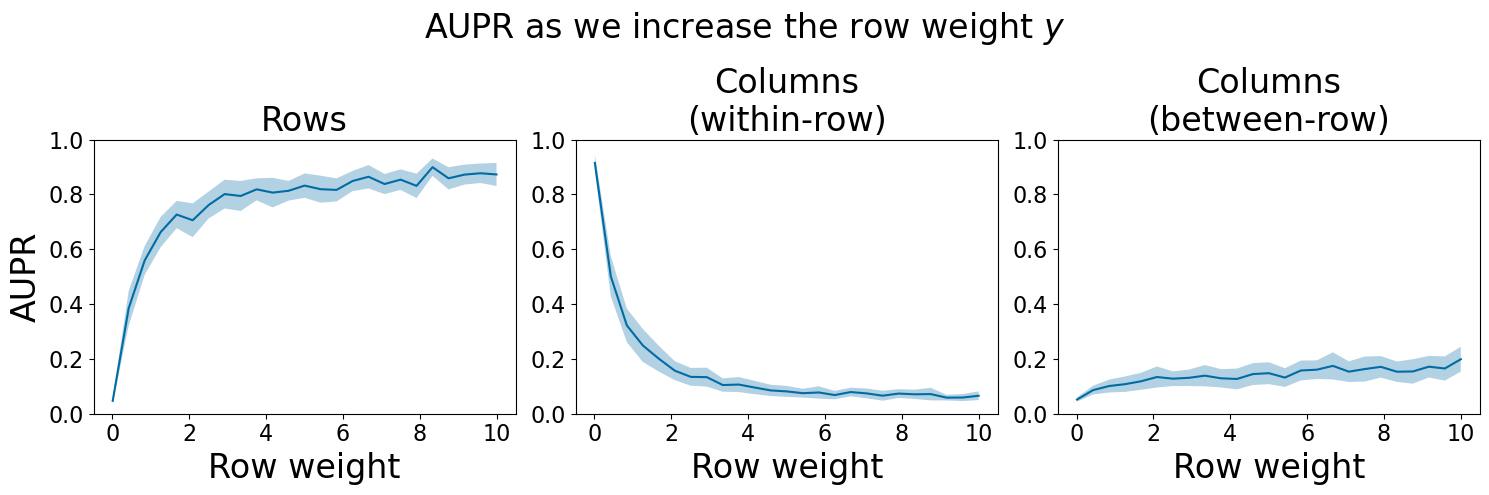

In [17]:
random.seed(SEED)
np.random.seed(SEED)

# Create a random graph
num_nodes = 50
num_trials = 50
row_ratios = np.linspace(0.01, 10, 25)

aus_1 = []
aus_2w = []
aus_2b = []
aus_1_var = []
aus_2w_var = []
aus_2b_var = []

for i, row_ratio in enumerate(row_ratios):
    graph1 = ig.Graph.Barabasi(n=num_nodes)
    graph2 = ig.Graph.Barabasi(n=num_nodes)
    graph3 = ig.Graph.Barabasi(n=num_nodes)
    if i % 2 == 0:
        print(f"Iteration {i+1}, Ratio {row_ratio}")
    _aus_1 = []
    _aus_2w = []
    _aus_2b = []
    for trial in range(num_trials):
        au_1, au_2w, au_2b = aupr(
            num_nodes,
            [graph1, graph2, graph3],
            row_coefficient=row_ratio
        )
        _aus_1.append(au_1)
        _aus_2w.append(au_2w)
        _aus_2b.append(au_2b)
    aus_1.append(np.mean(_aus_1))
    aus_2w.append(np.mean(_aus_2w))
    aus_2b.append(np.mean(_aus_2b))
    aus_1_var.append(np.var(_aus_1 - aus_1[-1]))
    aus_2w_var.append(np.var(_aus_2w - aus_2w[-1]))
    aus_2b_var.append(np.var(_aus_2b - aus_2b[-1]))

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))
ax1.plot(row_ratios, aus_1, label="Rows")
ax1.set_title("Rows")
ax2.plot(row_ratios, aus_2w, label="Columns (within-row)")
ax2.set_title("Columns\n(within-row)")
ax3.plot(row_ratios, aus_2b, label="Columns (between-row)")
ax3.set_title("Columns\n(between-row)")
ax1.set_xlabel("Row weight")
ax2.set_xlabel("Row weight")
ax3.set_xlabel("Row weight")
ax1.set_ylabel("AUPR")

ax1.fill_between(
    row_ratios,
    np.array(aus_1) - np.sqrt(np.array(aus_1_var)),
    np.array(aus_1) + np.sqrt(np.array(aus_1_var)),
    alpha=0.3
)
ax2.fill_between(
    row_ratios,
    np.array(aus_2w) - np.sqrt(np.array(aus_2w_var)),
    np.array(aus_2w) + np.sqrt(np.array(aus_2w_var)),
    alpha=0.3
)
ax3.fill_between(
    row_ratios,
    np.array(aus_2b) - np.sqrt(np.array(aus_2b_var)),
    np.array(aus_2b) + np.sqrt(np.array(aus_2b_var)),
    alpha=0.3
)

ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)
ax3.set_ylim(0, 1)

# Increase font size
for ax in [ax1, ax2, ax3]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(24)
    for item in ax.get_xticklabels() + ax.get_yticklabels():
        item.set_fontsize(16)

fig.suptitle("AUPR as we increase the row weight $y$", size=24)
fig.tight_layout()

fig.savefig('./out_figs/synthetic/row-precision-increase.pdf', bbox_inches="tight")

In [ ]:
random.seed(SEED)
np.random.seed(SEED)

# Create a random graph
num_nodes = 500
num_trials = 25
cb_ratios = np.linspace(0.01, 10, 10)

aus_1 = []
aus_2w = []
aus_2b = []
aus_1_var = []
aus_2w_var = []
aus_2b_var = []

for i, cb_ratio in enumerate(cb_ratios):
    graph1 = ig.Graph.Barabasi(n=num_nodes)
    graph2 = ig.Graph.Barabasi(n=num_nodes)
    graph3 = ig.Graph.Barabasi(n=num_nodes)
    if i % 2 == 0:
        print(f"Iteration {i+1}, Ratio {cb_ratio}")
    _aus_1 = []
    _aus_2w = []
    _aus_2b = []
    for trial in range(num_trials):
        au_1, au_2w, au_2b = aupr(
            num_nodes,
            [graph1, graph2, graph3],
            cb_cw_ratio=cb_ratio
        )
        _aus_1.append(au_1)
        _aus_2w.append(au_2w)
        _aus_2b.append(au_2b)
    aus_1.append(np.mean(_aus_1))
    aus_2w.append(np.mean(_aus_2w))
    aus_2b.append(np.mean(_aus_2b))
    aus_1_var.append(np.var(_aus_1 - aus_1[-1]))
    aus_2w_var.append(np.var(_aus_2w - aus_2w[-1]))
    aus_2b_var.append(np.var(_aus_2b - aus_2b[-1]))

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))
ax1.plot(cb_ratios, aus_1, label="Rows")
ax1.set_title("Rows")
ax2.plot(cb_ratios, aus_2w, label="Columns (within-row)")
ax2.set_title("Columns\n(within-row)")
ax3.plot(cb_ratios, aus_2b, label="Columns (between-row)")
ax3.set_title("Columns\n(between-row)")
ax1.set_xlabel("Ratio")
ax2.set_xlabel("Ratio")
ax3.set_xlabel("Ratio")
ax1.set_ylabel("AUPR")

ax1.fill_between(
    cb_ratios,
    np.array(aus_1) - np.sqrt(np.array(aus_1_var)),
    np.array(aus_1) + np.sqrt(np.array(aus_1_var)),
    alpha=0.3
)
ax2.fill_between(
    cb_ratios,
    np.array(aus_2w) - np.sqrt(np.array(aus_2w_var)),
    np.array(aus_2w) + np.sqrt(np.array(aus_2w_var)),
    alpha=0.3
)
ax3.fill_between(
    cb_ratios,
    np.array(aus_2b) - np.sqrt(np.array(aus_2b_var)),
    np.array(aus_2b) + np.sqrt(np.array(aus_2b_var)),
    alpha=0.3
)

ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)
ax3.set_ylim(0, 1)

# Increase font size
for ax in [ax1, ax2, ax3]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(24)

fig.suptitle("AUPR as we increase the between:within-row ratio $x$", size=24)
fig.tight_layout()

fig.savefig('./out_figs/synthetic/bw-ratio-change_500.pdf', bbox_inches="tight")

In [ ]:
random.seed(SEED)
np.random.seed(SEED)

# Create a random graph
num_nodes = 500
num_trials = 25
row_ratios = np.linspace(0.01, 10, 10)

aus_1 = []
aus_2w = []
aus_2b = []
aus_1_var = []
aus_2w_var = []
aus_2b_var = []

for i, row_ratio in enumerate(row_ratios):
    graph1 = ig.Graph.Barabasi(n=num_nodes)
    graph2 = ig.Graph.Barabasi(n=num_nodes)
    graph3 = ig.Graph.Barabasi(n=num_nodes)
    if i % 2 == 0:
        print(f"Iteration {i+1}, Ratio {row_ratio}")
    _aus_1 = []
    _aus_2w = []
    _aus_2b = []
    for trial in range(num_trials):
        au_1, au_2w, au_2b = aupr(
            num_nodes,
            [graph1, graph2, graph3],
            row_coefficient=row_ratio
        )
        _aus_1.append(au_1)
        _aus_2w.append(au_2w)
        _aus_2b.append(au_2b)
    aus_1.append(np.mean(_aus_1))
    aus_2w.append(np.mean(_aus_2w))
    aus_2b.append(np.mean(_aus_2b))
    aus_1_var.append(np.var(_aus_1 - aus_1[-1]))
    aus_2w_var.append(np.var(_aus_2w - aus_2w[-1]))
    aus_2b_var.append(np.var(_aus_2b - aus_2b[-1]))

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))
ax1.plot(row_ratios, aus_1, label="Rows")
ax1.set_title("Rows")
ax2.plot(row_ratios, aus_2w, label="Columns (within-row)")
ax2.set_title("Columns\n(within-row)")
ax3.plot(row_ratios, aus_2b, label="Columns (between-row)")
ax3.set_title("Columns\n(between-row)")
ax1.set_xlabel("Row weight")
ax2.set_xlabel("Row weight")
ax3.set_xlabel("Row weight")
ax1.set_ylabel("AUPR")

ax1.fill_between(
    row_ratios,
    np.array(aus_1) - np.sqrt(np.array(aus_1_var)),
    np.array(aus_1) + np.sqrt(np.array(aus_1_var)),
    alpha=0.3
)
ax2.fill_between(
    row_ratios,
    np.array(aus_2w) - np.sqrt(np.array(aus_2w_var)),
    np.array(aus_2w) + np.sqrt(np.array(aus_2w_var)),
    alpha=0.3
)
ax3.fill_between(
    row_ratios,
    np.array(aus_2b) - np.sqrt(np.array(aus_2b_var)),
    np.array(aus_2b) + np.sqrt(np.array(aus_2b_var)),
    alpha=0.3
)

ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)
ax3.set_ylim(0, 1)

# Increase font size
for ax in [ax1, ax2, ax3]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(24)
    for item in ax.get_xticklabels() + ax.get_yticklabels():
        item.set_fontsize(16)

fig.suptitle("AUPR as we increase the row weight $y$", size=24)
fig.tight_layout()

fig.savefig('./out_figs/synthetic/row-precision-increase_500.pdf', bbox_inches="tight")

# Convergence

In [10]:
random.seed(SEED)
np.random.seed(SEED)
num_nodes = 500
graph1 = ig.Graph.Barabasi(n=num_nodes)
graph2 = ig.Graph.Barabasi(n=num_nodes)
graph3 = ig.Graph.Barabasi(n=num_nodes)
data = fast_strong_product(
    random_graph(graph1),
    random_graph(graph2),
    random_graph(graph3)
)

results = strong_product_model(
    data_matrix=data,
    rho_rows=0.1,
    rho_cols_within_rows=0.1,
    rho_cols_between_rows=0.1,
    verbose=True,
    tol=1e-100,
    return_errors=True
)

Iteration 1: 33125.585429273255
Iteration 2: 19828.681962960283
logm result may be inaccurate, approximate err = 0.02320727913613361
Iteration 3: 14158.740910530963
logm result may be inaccurate, approximate err = 0.009972952497556288
Iteration 4: 11511.94080698461
logm result may be inaccurate, approximate err = 4.491821999208108e-05
Iteration 5: 10230.386232567776
logm result may be inaccurate, approximate err = 4.515057597475976e-05
Iteration 6: 9599.503328579187
logm result may be inaccurate, approximate err = 1.3727197804041713e-06
Iteration 7: 9521.185037864896
logm result may be inaccurate, approximate err = 4.551834190858594e-05
Iteration 8: 9482.063117659825
logm result may be inaccurate, approximate err = 4.553017871729404e-05
Iteration 9: 9477.17496763065
logm result may be inaccurate, approximate err = 1.5099969132525784e-05
Iteration 10: 9476.56398151035
Iteration 11: 9476.258490716747
Iteration 12: 9476.10574588651
Iteration 13: 9476.08665281476
Iteration 14: 9476.0818795

[73771.11906711 33125.58542927 19828.68196296 14158.74091053
 11511.94080698 10230.38623257  9599.50332858  9521.18503786
  9482.06311766  9477.17496763  9476.56398151  9476.25849072
  9476.10574589  9476.08665281  9476.08187955  9476.07949291
  9476.07919459  9476.07912     9476.07908271  9476.07906407
  9476.07905474  9476.07905008  9476.0790495   9476.07904921
  9476.07904906  9476.07904899  9476.07904897  9476.07904897
  9476.07904896  9476.07904896  9476.07904896  9476.07904896]


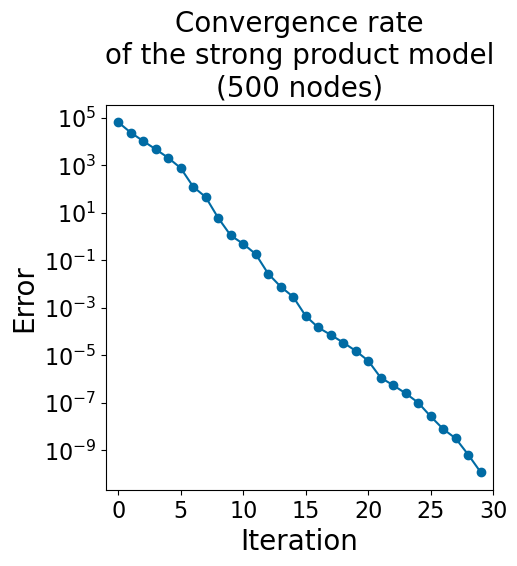

In [11]:
errors = np.array(results["errors"])
print(errors)
errors -= errors[-1]
errors = errors[:-2] # Second-to-last error is same b/c of convergence criterion
errors = np.abs(errors)

# Show convergence over time
fig, ax = plt.subplots(ncols=1, figsize=(5, 5))
ax.plot(errors, linestyle='-', marker='o')
ax.set_xlabel("Iteration")
ax.set_ylabel("Error")
ax.set_yscale("log")
ax.set_xlim(-1, len(errors))
ax.set_title(f"Convergence rate\nof the strong product model\n({num_nodes} nodes)")

# Increase font size
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(20)

for item in ax.get_xticklabels() + ax.get_yticklabels():
    item.set_fontsize(16)

fig.savefig('./out_figs/synthetic/convergence-rate.pdf', bbox_inches="tight")